In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from utility import analysis_parameters as ap
from utility import util
import cartopy.crs as ccrs
import numpy as np
import netCDF4 as nc
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

var="cltotal"
model="ICON"
topdown=True # False for NICAM and SAM; all else True

chunk_dict = {"time":80,"lat":71, "lon":71, "Xdim":1000, "ncol":1000}
diff=False
lev=0

colors=ap.COLORS
plt.rcParams['font.size']=16

In [12]:
# plt.rcParams

# Calculate the cloud top heights

In [2]:
ds = xr.open_dataset(ap.get_file(model, "TWP_3D", var), chunks=chunk_dict)[var]
if model=="GEOS" or model=="SCREAM" or model=="ICON":
    z = xr.open_dataset(ap.get_file(model, "TWP_3D", "zg"), chunks=chunk_dict).zg
    print(z[:,0].values)
elif model=="SAM":
    z = ds.z
    print(z[0].values)
elif model=="NICAM":
    z = ds.lev
    print(z[0].values)
if model=="GEOS":
    ds = ds[::3]
    z = z[::3]
    print(z[0].values)
    print(ds.time.values[0], z[0].time.values)
print(ds.shape, z.shape)
ds

[########################################] | 100% Completed | 403.54 ms
[[45120.61  45120.63  45120.637 ... 45120.203 45120.18  45120.15 ]
 [45121.227 45121.125 45121.293 ... 45120.38  45120.52  45120.44 ]
 [45120.42  45120.35  45120.477 ... 45120.613 45120.7   45120.75 ]
 ...
 [45120.957 45120.906 45120.938 ... 45120.984 45121.113 45121.17 ]
 [45120.598 45120.48  45120.723 ... 45122.188 45122.49  45122.547]
 [45122.24  45122.184 45122.23  ... 45120.664 45120.617 45120.6  ]]
(210, 77, 195442) (210, 76, 195442)


<xarray.DataArray 'cltotal' (time: 210, height: 77, cell: 195442)>
dask.array<open_dataset-247a05a734dcf423abf5296eee2bb08acltotal, shape=(210, 77, 195442), dtype=float32, chunksize=(80, 77, 195442), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-28T21:00:00
    clon     (cell) float64 dask.array<chunksize=(195442,), meta=np.ndarray>
    clat     (cell) float64 dask.array<chunksize=(195442,), meta=np.ndarray>
  * height   (height) float64 14.0 15.0 16.0 17.0 18.0 ... 87.0 88.0 89.0 90.0
Dimensions without coordinates: cell
Attributes:
    standard_name:  mass_fraction_of_cloud_ice_in_air
    long_name:      Specific cloud ice content (diagnostic) 
    units:          kg kg-1
    param:          213.1.0
    CDI_grid_type:  unstructured
    origin:         QI_DIA

In [3]:
thres=1e-4

#initialize arrays to zeros
cldtop = np.zeros(ds[:,0].shape)
cldtopind = np.zeros(ds[:,0].shape)

if model=="SAM":
    for l in range(1,len(ds.z)):
        print(-l, z[-l])
        cldtop = np.where((cldtop==0)&(ds.isel(z=-l)>thres), z[-l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(z=-l)>thres), -l, cldtopind)
elif model=="ICON":
    for l in range(18,len(ds.height)-1):
        print(l)
        cldtop = np.where((cldtop==0)&(ds.isel(height=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(height=l)>thres), l, cldtopind)
elif model=="SCREAM":
    for l in range(0,len(ds.lev)-1):
        print(l, z[0,l,0].values)
        cldtop = np.where((cldtop==0)&(ds.isel(lev=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(lev=l)>thres), l, cldtopind)
elif model=="GEOS":
    for l in range(75,len(ds.lev)-1):
        print(l, z[0,l,0].values)
        cldtop = np.where((cldtop==0)&(ds.isel(lev=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(lev=l)>thres), l, cldtopind)
elif model=="NICAM": #NICAM
    for l in range(1,len(ds.lev)-1):
        print(-l, z[0,-l,0].values)
        cldtop = np.where((cldtop==0)&(ds.isel(lev=-l)>thres), z[:,-l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(lev=-l)>thres), -l, cldtopind)
else:
    raise Exception("model not defined")

18
[########################################] | 100% Completed | 3.93 sms
[########################################] | 100% Completed | 302.40 ms
[########################################] | 100% Completed | 204.45 ms
19
[########################################] | 100% Completed | 1.71 sms
[########################################] | 100% Completed | 202.01 ms
[########################################] | 100% Completed | 202.20 ms
20
[########################################] | 100% Completed | 1.71 sms
[########################################] | 100% Completed | 201.62 ms
[########################################] | 100% Completed | 202.14 ms
21
[########################################] | 100% Completed | 1.82 sms
[########################################] | 100% Completed | 202.16 ms
[########################################] | 100% Completed | 202.26 ms
22
[########################################] | 100% Completed | 1.82 sms
[########################################] | 100% Comp

In [4]:
cldtop, thres

(array([[   0.        ,    0.        ,    0.        , ..., 2035.40075684,
         1564.29541016, 2035.29406738],
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        ...,
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [ 635.46972656,  635.4833374 ,  635.48828125, ...,    0.        ,
            0.        ,    0.        ]]),
 0.0001)

In [5]:
if model=="GEOS":
    da = xr.DataArray(cldtop, dims=["time","Xdim"], coords={"time":ds.time,"Xdim":ds.Xdim}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","Xdim"], coords={"time":ds.time,"Xdim":ds.Xdim}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})
elif model=="SCREAM":
    da = xr.DataArray(cldtop, dims=["time","ncol"], coords={"time":ds.time,"ncol":ds.ncol}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","ncol"], coords={"time":ds.time,"ncol":ds.ncol}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})
elif model=="ICON":
    da = xr.DataArray(cldtop, dims=["time","cell"], coords={"time":ds.time,"cell":ds.cell}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","cell"], coords={"time":ds.time,"cell":ds.cell}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})
else:
    da = xr.DataArray(cldtop, dims=["time","lat","lon"], coords={"time":ds.time,"lat":ds.lat,"lon":ds.lon}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","lat","lon"], coords={"time":ds.time,"lat":ds.lat,"lon":ds.lon}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})


In [6]:
model

'ICON'

In [7]:
file = "/work/bb1153/b380883/TWP/TWP_{}_cldtop_height_20200130-20200228.nc".format(model)
# ds = xr.Dataset({"cldtop_height{:.0e}".format(thres):da, "cldtop_ind{:.0e}".format(thres):daind},
#                 attrs={"name":"cloud top height", "deets":"calculated in cloudtop.ipynb"})
ds = xr.open_dataset(file)
ds = ds.assign({"cldtop_height{:.0e}".format(thres):da, "cldtop_ind{:.0e}".format(thres):daind})
ds

<xarray.Dataset>
Dimensions:             (time: 210, cell: 195442)
Coordinates:
  * time                (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02...
  * cell                (cell) int64 0 1 2 3 4 ... 195438 195439 195440 195441
Data variables:
    cldtop_height1e-07  (time, cell) float64 ...
    cldtop_ind1e-07     (time, cell) float64 ...
    cldtop_height1e-06  (time, cell) float64 ...
    cldtop_ind1e-06     (time, cell) float64 ...
    cldtop_height1e-05  (time, cell) float64 ...
    cldtop_ind1e-05     (time, cell) float64 ...
    cldtop_height1e-04  (time, cell) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cldtop_ind1e-04     (time, cell) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    name:     cloud top height
    deets:    calculated in cloudtop.ipynb

In [8]:
file

'/work/bb1153/b380883/TWP/TWP_ICON_cldtop_height_20200130-20200228.nc'

In [9]:
# ! rm /work/bb1153/b380883/TWP/TWP_ICON_cldtop_height_20200130-20200228.nc
ds.to_netcdf(file)



# Plotting cldtop height vs olr

In [2]:
# file = "/work/bb1153/b380883/TWP/TWP_{}_cldtop_height_20200130-20200228.nc".format(m)
# ds = xr.open_dataset(file, chunks=chunk_dict)

(3, 4)
0 GEOS
	shapes of ds and olr match: True
[########################################] | 100% Completed | 13.14 s
[########################################] | 100% Completed | 3.32 sms
23316480
[########################################] | 100% Completed | 9.46 ss
[########################################] | 100% Completed | 4.54 sms
23316480
[########################################] | 100% Completed | 9.94 ss
[########################################] | 100% Completed | 4.95 sms
23316480
[########################################] | 100% Completed | 4.91 sms
[########################################] | 100% Completed | 5.20 sms
[########################################] | 100% Completed | 4.98 sms
1 ICON
	shapes of ds and olr match: True
[########################################] | 100% Completed | 1.83 sms
[########################################] | 100% Completed | 603.97 ms
41042820
[########################################] | 100% Completed | 2.12 sms
[########################

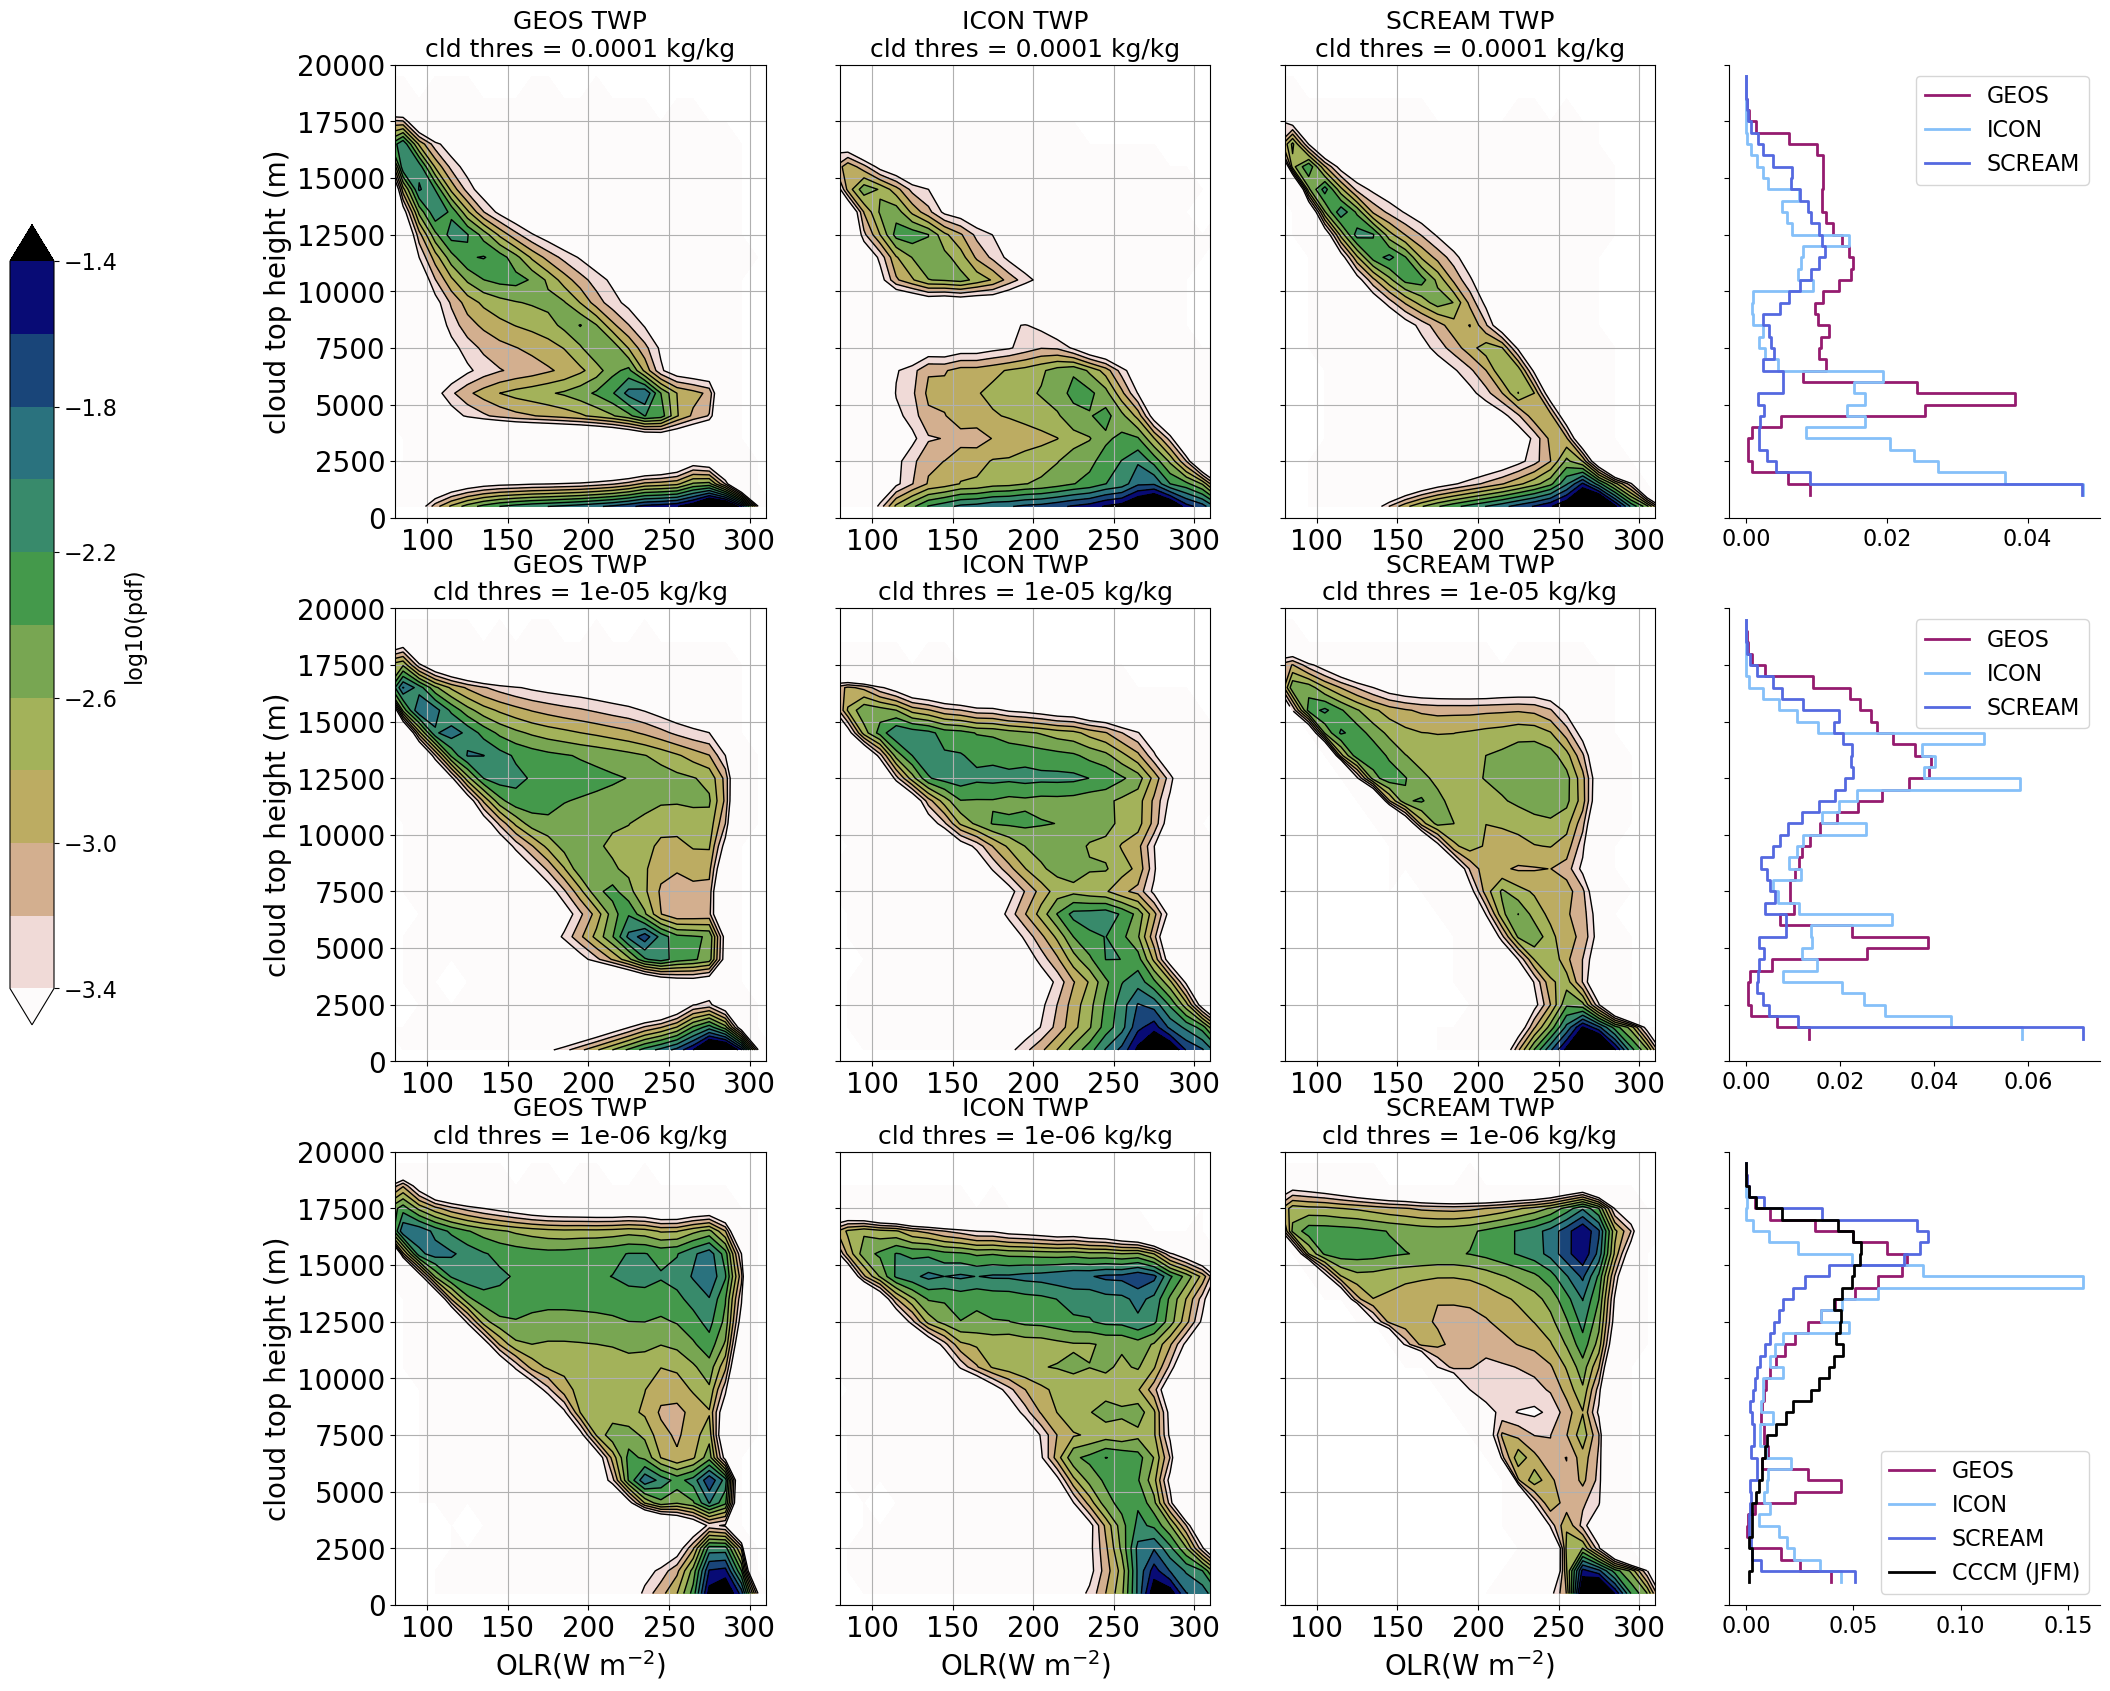

In [24]:
models=["GEOS","ICON","SCREAM"]
# models = ["GEOS"]
region="TWP"
mod_lab=""

fig, ax = plt.subplots(3,len(models)+1, figsize=(22,20), sharey=True)
print(ax.shape)

for i,m in enumerate(models):
    print(i, m)   
    file = "/work/bb1153/b380883/TWP/TWP_{}_cldtop_height_20200130-20200228.nc".format(m)
    ds = xr.open_dataset(file, chunks=chunk_dict)

    olr = ap.load_olr(m,"TWP", r=0).sel(time=ds.time)
    print("\tshapes of ds and olr match:", ds['cldtop_height1e-04'].shape==olr.shape)
    
    # plot
    util.dennisplot("density",olr.values.flatten(), ds['cldtop_height1e-04'].values.flatten(), 
                    ax=ax[0,i], model=m, region=region,
                    cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                    ybins=np.arange(0,20001,1000), colorbar_on=False, draw_line=False)
    ax[0,i].set_ylim([0,20000])
    ax[0,i].set_xlim([80,310])
    ax[0,i].set_title("{} TWP\ncld thres = {} kg/kg".format(m, 1e-4), fontsize=18)
    util.dennisplot("density",olr.values.flatten(), ds['cldtop_height1e-05'].values.flatten(), 
                    ax=ax[1,i], model=m, region=region,
                    cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                    ybins=np.arange(0,20001,1000), colorbar_on=False, draw_line=False)
    ax[1,i].set_ylim([0,20000])
    ax[1,i].set_xlim([80,310])
    ax[1,i].set_title("{} TWP\ncld thres = {} kg/kg".format(m, 1e-5), fontsize=18)

    _, im = util.dennisplot("density",olr.values.flatten(), ds['cldtop_height1e-06'].values.flatten(), 
                    ax=ax[2,i], model=m, region=region,
                    cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                    ybins=np.arange(0,20001,1000), colorbar_on=False, draw_line=False)
    ax[2,i].set_ylim([0,20000])
    ax[2,i].set_xlim([80,310])
    ax[2,i].set_title("{} TWP\ncld thres = {} kg/kg".format(m, 1e-6), fontsize=18)

    ax[i,0].set_ylabel("cloud top height (m)")
    ax[1,i].set_ylabel("")
    ax[2,i].set_ylabel("")

    # cth pdf on far right plot
    zbins = np.arange(0,20001,500)
    hist0, _ = np.histogram(ds['cldtop_height1e-04'].values.flatten(), bins=zbins)
    hist0 = hist0/np.prod(np.shape(ds['cldtop_height1e-04']))
    ax[0,3].step(hist0[2:], zbins[2:-1], label=m, lw=2, where='pre', color=colors[m])
    hist1, _ = np.histogram(ds['cldtop_height1e-05'].values.flatten(), bins=zbins)
    hist1 = hist1/np.prod(np.shape(ds['cldtop_height1e-05']))
    ax[1,3].step(hist1[2:], zbins[2:-1], label=m, lw=2, where='pre', color=colors[m])
    hist2, _ = np.histogram(ds['cldtop_height1e-06'].values.flatten(), bins=zbins)
    hist2 = hist2/np.prod(np.shape(ds['cldtop_height1e-06']))
    ax[2,3].step(hist2[2:], zbins[2:-1], label=m, lw=2, where='pre', color=colors[m])

    mod_lab+=m[:2]

# add CCCM cldtop height distribution to bottom right plot

# olr = xr.open_dataset(ap.CCCM_JFM).CERES_LW_TOA_flux___upwards
cth = xr.open_dataset(ap.CCCM_JFM).Mean_CALIPSO_5_km_cloud_layer_top_height.mean(axis=1)
cth = np.where(np.isnan(cth), 0, cth)

hist, _ = np.histogram(cth*1000, bins=zbins)
hist = hist/np.prod(np.shape(cth))
ax[2,3].step(hist[2:], zbins[2:-1], where='pre', lw=2, color="k", label="CCCM (JFM)")

mod_lab+="_CCCM"

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel("")
        if i==0:
            ax[j,3].legend(loc="best")
            ax[j,3].spines[['right', 'top']].set_visible(False)
            ax[j,3].set_ylabel("")
            if j>0:
                ax[j,3].set_xlabel("")

ax[0,1].set_ylabel("")
ax[0,2].set_ylabel("")
# ax[2,3].set_xlabel("pdf")
cbar_ax = fig.add_axes([-0.05, 0.4, 0.02, 0.4])
cb = fig.colorbar(im, cax=cbar_ax, label="log10(pdf)")

# axcccm = fig.add_axes([0., 0., 0.25, 0.33], sharey=ax[1,1])
# util.dennisplot("density",olr.values.flatten(), cth.flatten()*1000, 
#                 ax=axcccm, model=model, region=region,
#                 cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
#                 ybins=np.arange(0,20001,500), colorbar_on=True, draw_line=False)
# axcccm.set(ylabel="Height (km)")
# axcccm.set_title("CCCM (JFM) TWP", fontsize=18)

print("saved as ",mod_lab)
plt.savefig("../plots/TWP/cldtop_v_olr_{}.png".format(mod_lab),dpi=120, bbox_inches="tight", pad_inches=0.5)
plt.show()

In [13]:
# for i in [cldtop_low, cldtop_med, cldtop_hgh]:
#     print((i.where(i==0).count()/i.count()).values)


[########################################] | 100% Completed |  0.7s
0.17746782865855631
[########################################] | 100% Completed |  0.8s
0.3018176683413582
[########################################] | 100% Completed |  0.7s
0.6133990503810179


# Single model CTH vs OLR


In [18]:
model="CCCM"
region="TWP"
nlayer="mean"
olr = xr.open_dataset(ap.CCCM_JFM).CERES_LW_TOA_flux___upwards
if nlayer=="mean":
    cth = xr.open_dataset(ap.CCCM_JFM).Mean_CALIPSO_5_km_cloud_layer_top_height.mean(axis=1)
else:
    cth = xr.open_dataset(ap.CCCM_JFM).Mean_CALIPSO_5_km_cloud_layer_top_height[:,nlayer]
print(olr.shape, cth.shape)

(15352,) (15352,)


In [19]:
cth = np.where(np.isnan(cth), 0, cth)

15352


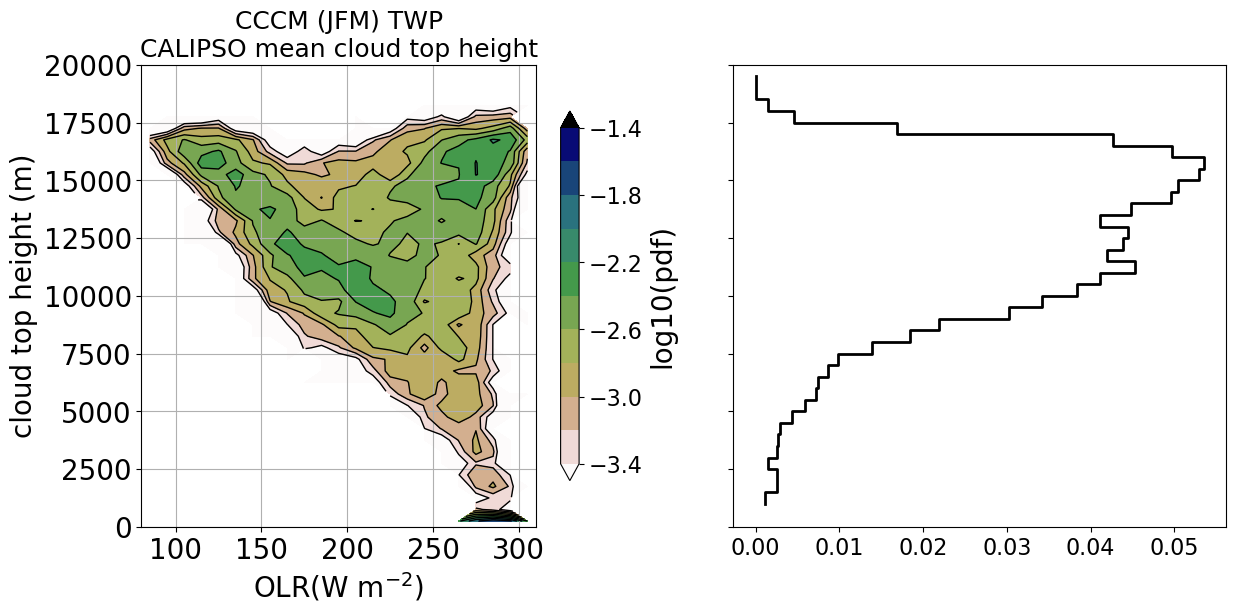

In [23]:
fig, [ax,axpdf] = plt.subplots(1,2, figsize=(14,6), sharey=True)
util.dennisplot("density",olr.values.flatten(), cth.flatten()*1000, 
                ax=ax, model=model, region=region,
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                ybins=np.arange(0,20001,500), colorbar_on=True, draw_line=False)
ax.set(ylim=[0,20000], ylabel="cloud top height (m)")
ax.set_title("CCCM (JFM) TWP\nCALIPSO mean cloud top height", fontsize=18)

hist, _ = np.histogram(cth*1000, bins=zbins)
hist = hist/np.prod(np.shape(cth))
axpdf.step(hist[2:], zbins[2:-1], where='pre', lw=2, color="k")

plt.savefig("../plots/TWP/cldtop_v_olr_CCCM_{}.png".format(nlayer))
plt.show()

## Single model CTH vs OLR with IWP shaded in side-by-side plot

In [14]:
iwp = ap.load_iwp(model,"TWP",total=False, chunks=chunk_dict)[::12][:-1]*1000#.sel(time=cldtop_low.time)*1000
iwp

returned ice only GEOS TWP


<xarray.DataArray 'clivi' (time: 239, Xdim: 97152)>
dask.array<mul, shape=(239, 97152), dtype=float32, chunksize=(7, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30 ... 2020-02-28T18:00:00
    lons     (Xdim) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lats     (Xdim) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: Xdim

In [15]:
print(iwp.shape, olr.shape, cldtop_low.shape)
print(iwp.time[0].values, olr.time[0].values, cldtop_low.time[0].values)
print(iwp.time[-1].values, olr.time[-1].values, cldtop_low.time[-1].values)
# olr = olr.sel(time=iwp.time)
# cldtop_low = cldtop_low.sel(time=iwp.time)

(239, 97152) (239, 97152) (239, 97152)
2020-01-30T00:00:00.000000000 2020-01-30T00:00:00.000000000 2020-01-30T00:00:00.000000000
2020-02-28T18:00:00.000000000 2020-02-28T18:00:00.000000000 2020-02-28T18:00:00.000000000


In [16]:
print(iwp.shape, olr.shape, cldtop_low.shape)

(239, 97152) (239, 97152) (239, 97152)


[########################################] | 100% Completed | 538.52 s
[########################################] | 100% Completed | 2.12 ss
23219328
[########################################] | 100% Completed | 11.78 s
[########################################] | 100% Completed | 406.46 ms
[########################################] | 100% Completed | 17.31 s


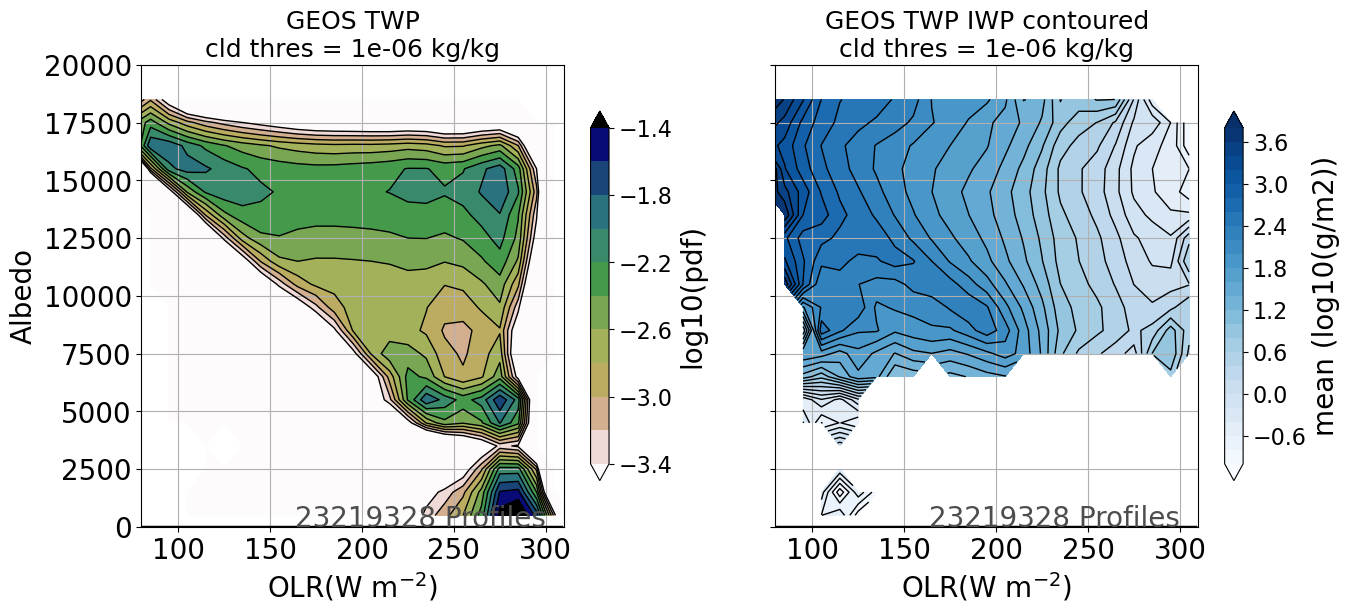

In [17]:
region="TWP"

fig, ax = plt.subplots(1,2, figsize=(15,6), sharey=True)
util.dennisplot("density",olr.values.flatten(), cldtop_low.values.flatten(), 
                ax=ax[0], model=model, region=region,
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                ybins=np.arange(0,20000,1000), colorbar_on=True)
ax[0].set_ylim([0,20000])
ax[0].set_title("{} TWP\ncld thres = {} kg/kg".format(model, 1e-6), fontsize=18)

util.dennisplot("mean",olr.values.flatten(), cldtop_low.values.flatten(), 
                var=np.log10(iwp.values.flatten()),
                ax=ax[1], model=model, region=region,
                var_name="log10(IWP)", units="log10(g/m2)",
                cmap="Blues", levels=np.arange(-1,4,0.2), 
                ybins=np.arange(0,20000,1000), colorbar_on=True)
ax[1].set_ylim([0,20000])
ax[1].set(ylabel="")
ax[1].set_title("{} TWP IWP contoured\ncld thres = {} kg/kg".format(model, 1e-6), fontsize=18)


plt.savefig("../plots/TWP/cldtop_v_olr_iwp_{}.png".format(model),dpi=120)
plt.show()